# Predictors autocorrelation analysis

This code tests the autocorrelation of environmental variables in the area of China, across the past 8000 years. It is used to select predictors for the analysis from the clusters of highly correlated variables and plots them as [ESM 6](../outputs/ESM_6.pdf).

In [ ]:
# Libraries:

library(here) # setting the paths
library(corrplot) # plotting correlation
library(dendextend) # plotting dendrogram
library(data.table) # working with data frames:
library(raster) # working with raster layers

In [2]:
### Define paths

# Paths to existing files
path2past <- here("data","environmental","past")
path2present <- here("data","environmental","present","masked")
path2env_table<-here("outputs","01_01_Predictor_variables.csv")

# Paths to outputs
path2pearson <- here("outputs","02_01_Predictors_autocorrelation.csv")
path2corrplot <- here("outputs","02_02_Predictors_corrplot.tiff")
path2dendrogram<-here("outputs","ESM_6.pdf")

In [3]:
### Load data
# Load the list of variables names (will be needed to change the names later):
var_list<-read.csv(path2env_table)

In [4]:
# Get list of folders that contain past environmental layers
layers<-list.files(path=path2past,full.names=TRUE)
# Include only npp, and bioclimatic variables, with the exception of BIO3, BIO14, and BIO15, as these are known to cause issues
layers<-subset(layers,lapply(layers, grepl,pattern="BIO|npp")==TRUE &lapply(layers, grepl,pattern="BIO3|BIO14|BIO15")==FALSE)
layers<-paste(layers,"//masked//",sep="")
# Get list of files in the folder for each variable
layers<-lapply(layers,list.files,full.names=TRUE, pattern=".tif")

In [5]:
# Make a list of stacks for each of the environmental variables:
egv_list<-lapply(layers,raster::stack)
# Make a list of stacks grouped by period
egv_by_period<-c()
for(i in 1:length(layers[[1]])){
a<-raster::stack(lapply(egv_list, subset,i))
egv_by_period[[i]]<-c(a)}
egv_by_period <- unlist(egv_by_period)

In [6]:
# Load layers for present climatic variables:
p_layers<-list.files(path=path2present,pattern='tif',full.names=TRUE)
# Get only the layers related to bioclimatic variables and net primary productivity, and exclude bioclimatic variables 3, 14 and 15, because of the recommendations
p_layers<-subset(p_layers,lapply(p_layers, grepl,pattern="BIO|npp")==TRUE &lapply(p_layers, grepl,pattern="BIO3|BIO14|BIO15")==FALSE)
# Join all rasters in a single object
egv<-stack(p_layers)

In [7]:
# Extract the dataframe of variables from all of the layers
prd_list<-lapply(egv_by_period,values)
prd_list<-lapply(prd_list,as.data.frame)
prd_list<-lapply(prd_list,function(x){colnames(x)<-sub('_.*','',colnames(x))
                                      return(x)})

# Also extract the dataframe of variables for the present layer:
pres<-values(egv)

In [8]:
# Merges the data frame of present predictors with a data frame of past predictors
predictors<-rbind(pres,rbindlist(prd_list))

In [9]:
### Calculate the correlation coefficient matrix
pearson<-cor(predictors, method = "pearson",use="complete.obs")
# Save the correlation coefficient matrix to csv
write.csv(pearson, file=path2pearson,row.names=TRUE)

In [10]:
### Create a graph showing the correlation coefficients
# Set color palette
col <- colorRampPalette(c("#BB4444", "#EE9988", "#FFFFFF", "#77AADD", "#4477AA"))

# Create a correlation plot and save it as a tiff file:
tiff(path2corrplot, units="cm", width=17.4, height=17.4, res=600,bg = "transparent")
corrplot(as.matrix(pearson), method="color", col=col(200),  
         type="upper", order="hclust", 
         addCoef.col = "black", # Add coefficient of correlation
         tl.col="black", tl.srt=45, #Text label color and rotation
         # Combine with significance
         sig.level = 0.01, insig = "blank", 
         # hide correlation coefficient on the principal diagonal
         diag=FALSE,number.cex=0.4,tl.cex=0.5
         )
dev.off()

png 
  2

In [11]:
### Plot the dendrogram:
# Transform the correlation coefficient into a data.frame
cor.df<-as.data.frame(pearson)
# Change the names for plotting in the dendrogram
var_names<-colnames(cor.df)
rownames(cor.df)<-colnames(cor.df) <-unlist(lapply(var_names,function(x){return(var_list[which(var_list[,1]==x),2])}))
# Transfrom correlation matrix to distances
var.dist <- abs(as.dist(cor.df))
# Calculate dendrogram based on distance (less distance = more correlation)
var.cluster <- hclust(1-var.dist)
# Turn into dendrogram
dd<-as.dendrogram(var.cluster)

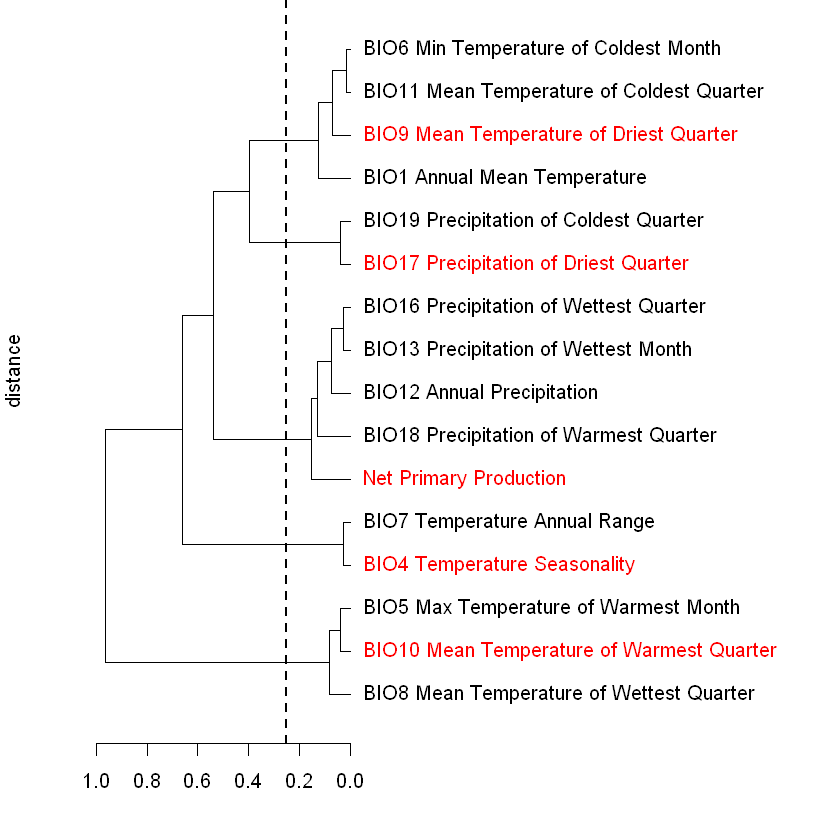

In [12]:
# Plot the dendrogram showing the clusters of higly correlated predictors:
labels_colors(dd) <- c("black","red","black","red","black","red","black","black","black","black","red","black","black","red","black","black")
#pdf(path2dendrogram, width=6.85, height=6.85,bg = "transparent")
par(mar=c(4,4,0,20))
plot(dd, main="",ylab="distance", xlab="",sub=NA, cex=0.75,col=c("red","blue","black","yellow"),horiz=T)
abline(v=0.25, lty=2, lwd=2)
#dev.off()